In [1]:
import streamlit as st
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#https://github.com/portfolioplus/pytickersymbols
from pytickersymbols import PyTickerSymbols
import finnhub
from datetime import datetime
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
nltk.download("vader_lexicon")
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from ta import add_all_ta_features 
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alexander\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Alexander\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def get_ticker():
    stock_data = PyTickerSymbols()
    indices = stock_data.get_all_indices()
    tickers = []
    for index in indices:
        tickers.append(stock_data.get_yahoo_ticker_symbols_by_index(index))
    tickers_flat = [item for sublist in tickers for item in sublist]
    tickers_flater = [item for sublist in tickers_flat for item in sublist]
    return sorted(tickers_flater)

#fetch all tickers
ticks = get_ticker()
ticks = list(np.unique(ticks))

In [3]:
slct = "TSLA"

In [6]:
def get_stock(slct):
    stock = yf.Ticker(slct)
    return stock
  
stock = get_stock("TSLA")

In [5]:
hist = stock.history(period = 'max')
hist['datetime']=hist.index
hist.reset_index()
hist['datetime']=hist['datetime'].astype('datetime64[ns]')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

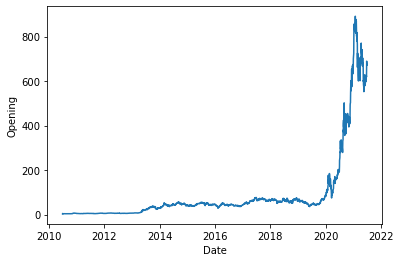

In [8]:
_=plt.plot(hist.datetime, hist["Open"])
_=plt.xlabel("Date")
_=plt.ylabel("Opening")
plt.show()

In [9]:
finnhub_client = finnhub.Client(api_key="c2si65iad3ic1qis06lg")
result=(finnhub_client.company_news(slct, _from="2020-11-15", to="2021-06-03"))
news=pd.DataFrame(result)
for i in range(news.shape[0]):
    news.datetime[i]= datetime.utcfromtimestamp(news.datetime[i]).strftime('%Y-%m-%d')
try:
    news['datetime']=news['datetime'].astype('datetime64[ns]')
    df=news.merge(hist,on='datetime',how="left")
    for i in range(df.shape[0]):
        df.summary[i] = strip_numeric(df.summary[i])
        df.summary[i] = strip_punctuation(df.summary[i])
        df.summary[i] = strip_multiple_whitespaces(df.summary[i])
        df.summary[i] = df.summary[i].lower()
        
    for i in range(df.shape[0]):
        df.headline[i] = strip_numeric(df.headline[i])
        df.headline[i] = strip_punctuation(df.headline[i])
        df.headline[i] = strip_multiple_whitespaces(df.headline[i])
        df.headline[i] = df.headline[i].lower()
        
    sid = sia()
    df['sentiment_vd_headline'] = df['headline'].apply(lambda headline: sid.polarity_scores(headline)['compound'])
    df['sentiment_vd_summary'] = df['summary'].apply(lambda summary: sid.polarity_scores(summary)['compound'])
    print("Sentiment analysis of headlines:", df.sentiment_vd_headline.mean())
    print("Sentiment analysis of summary:", df.sentiment_vd_summary.mean())
    
except:
    print("No sentiment analysis possible")

<ipython-input-9-2f93e7fdd9c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news.datetime[i]= datetime.utcfromtimestamp(news.datetime[i]).strftime('%Y-%m-%d')
C:\Users\Alexander\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-9-2f93e7fdd9c0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.summary[i] = strip_numeric(

Sentiment analysis of headlines: 0.07059720000000007
Sentiment analysis of summary: 0.1701421999999998


In [10]:
def get_news(company, date_from='2021-06-01', date_to=None):
    '''
    returns dataframe with average sentiment of news headline and sentiment of news summary for every date in a given timeframe
    company: symbol, example ZM
    date_from: string format yyyy-mm-dd
    date_to: string format yyyy-mm-dd
    '''
    sid = sia()
    if date_to is None:
        date_to = datetime.today().strftime("%Y-%m-%d")
    URL = 'https://finnhub.io/api/v1/company-news?symbol={}&from={}&to={}&token=c2si65iad3ic1qis06lg'.format(company, date_from, date_to)
    r = requests.get(URL)
    news_df = pd.DataFrame(r.json())
    news_df['datetime'] = [datetime.utcfromtimestamp(i).strftime('%Y-%m-%d') for i in news_df.datetime]
    news_df.drop(['id','image', 'related','source', 'url'], axis=1, inplace=True)
    news_df['headline_sentiment'] = [sid.polarity_scores(c)['compound'] for c in news_df['headline']]
    news_df['summary_sentiment'] = [sid.polarity_scores(c)['compound'] for c in news_df['summary']]
    
    news_dates = news_df.groupby(['datetime']).mean().sort_index().reset_index()

    news_dates['Date'] = pd.to_datetime(news_dates['datetime'], format='%Y-%m-%d')
    return news_dates

In [11]:
def get_recommendation_trends(company):
    URL = 'https://finnhub.io/api/v1/stock/recommendation?symbol={}&token=c2si65iad3ic1qis06lg'.format(company)
    r = requests.get(URL)
    recommendation_df = pd.DataFrame(r.json())
    dfs = []
    for i, month in recommendation_df.period.iteritems():
        period = month
        df_month = pd.DataFrame({
        'period': pd.date_range(
            start = pd.Timestamp(period),                        
            end = pd.Timestamp(period) + pd.offsets.MonthEnd(0),  # <-- 2018-08-31 with MonthEnd
            freq = 'D'
            )
        })
        df_month['month'] = month
        dfs.append(df_month)
    df = pd.concat(dfs)
    df.period = [datetime.strftime(x, '%Y-%m-%d') for x in df.period]
    df = df.merge(recommendation_df,how='left', left_on='month', right_on='period')
    df.drop(['month','period_y'], axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['period_x'], format='%Y-%m-%d')
    return df.drop(['period_x'],1)

In [12]:
add_all_ta_features(
    hist, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
news_df = get_news(slct)
trend_df = get_recommendation_trends(slct)
data = hist.merge(news_df, how='inner', on='Date').merge(trend_df, how='inner', on='Date').drop(['symbol','datetime_y','datetime_x'],1)
print('Data to train the model on')
data

C:\Users\Alexander\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Alexander\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Data to train the model on


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,volume_adi,volume_obv,...,others_dr,others_dlr,others_cr,headline_sentiment,summary_sentiment,buy,hold,sell,strongBuy,strongSell
0,2020-05-27,164.171997,165.542007,157.000000,164.046005,57747500,0,0.0,2.246103e+09,3180140000,...,0.166084,0.165947,3333.361437,0.202300,0.848100,2,16,10,6,5
1,2021-06-15,616.690002,616.789978,598.229980,599.359985,17764100,0,0.0,3.469785e+09,5060213500,...,-2.967511,-3.012432,12444.160751,0.102700,0.000000,9,14,6,10,4
2,2021-06-16,597.539978,608.500000,593.500000,604.869995,22144100,0,0.0,3.481211e+09,5082357600,...,0.919316,0.915116,12559.481176,0.164571,0.279035,9,14,6,10,4
3,2021-06-17,601.890015,621.469971,601.340027,616.599976,22701400,0,0.0,3.492928e+09,5105059000,...,1.939256,1.920693,12804.980982,0.103514,0.329052,9,14,6,10,4
4,2021-06-18,613.369995,628.349976,611.799988,623.309998,24528400,0,0.0,3.502517e+09,5129587400,...,1.088229,1.082351,12945.416774,0.047695,0.229330,9,14,6,10,4
5,2021-06-21,624.479980,631.390015,608.880005,620.830017,24812700,0,0.0,3.504050e+09,5104774700,...,-0.397873,-0.398666,12893.512619,0.090558,0.287131,9,14,6,10,4
6,2021-06-22,618.250000,628.570007,615.500000,623.710022,19158900,0,0.0,3.508960e+09,5123933600,...,0.463896,0.462823,12953.788989,0.090519,0.168026,9,14,6,10,4
7,2021-06-23,632.000000,657.200012,630.039978,656.570007,31099200,0,0.0,3.538617e+09,5155032800,...,5.268472,5.134377,13641.524154,0.081318,0.235430,9,14,6,10,4
8,2021-06-24,674.989990,697.619995,667.609985,679.820007,45982400,0,0.0,3.530052e+09,5201015200,...,3.541130,3.479874,14128.129441,0.123891,0.266510,9,14,6,10,4
9,2021-06-25,689.580017,693.809998,668.700012,671.869995,32429000,0,0.0,3.505810e+09,5168586200,...,-1.169429,-1.176321,13961.741571,0.089182,0.256188,9,14,6,10,4


In [13]:
def predict(data, move_days=7):
    # shifted values column, like this the model can learn what the price is going to be x days later
    data["shift_close"]=data[["Close"]].shift(-move_days)
    #x without the NaNs 
    X = data.drop(['shift_close','Date'],1)[:-move_days]
    y = data[['shift_close']][:-move_days]
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

    # training a model on the dataset where we have all data
    param_grid = {'min_samples_leaf': [2,3,5,10,20], 'n_estimators': [3,5,10,50,100], 'max_depth':[20,30,40]}
    rf = RandomForestRegressor(random_state = 42)
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)
    grid_search.fit(X_train, y_train)
    params = grid_search.best_params_

    rf=RandomForestRegressor(min_samples_leaf=params['min_samples_leaf'], n_estimators=params['n_estimators'], max_depth = params['max_depth'],random_state=42)
    rf.fit(X_train, y_train)
    y_pred_existing=rf.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred_existing)

    # View accuracy score
    score = rf.score(X_test, y_pred_existing)

    # Now the X variable is going to be the features for the days where we have no "in x Days price"
    last_days=data.tail(move_days)
    X_pred=last_days.drop(['shift_close','Date'],1)
    
    #values for the next 7 days 
    pred=rf.predict(X_pred)
    #predicted_dates = data['Date']
    last_days['shift_close'] = pred
    
    return last_days, MSE, score

In [69]:
predicted, MSE, score =predict(data)

C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricW

In [92]:
predicted.index = predicted.Date
predicted.index = predicted.index.shift(-4, freq = "D")
predicted.index

DatetimeIndex(['2021-06-28', '2021-07-01', '2021-07-02', '2021-07-03',
               '2021-07-04', '2021-07-05', '2021-07-08'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [37]:
save = predicted
print(predicted['Date'])
save.index = save.index.shift(7, freq='D')
save.index
save.shift_close

Date
2021-06-25   2021-06-18
2021-06-28   2021-06-21
2021-06-29   2021-06-22
2021-06-30   2021-06-23
2021-07-01   2021-06-24
2021-07-02   2021-06-25
2021-07-05   2021-06-28
Freq: B, Name: Date, dtype: datetime64[ns]


Date
2021-07-02    668.98666
2021-07-05    668.98666
2021-07-06    668.98666
2021-07-07    668.98666
2021-07-08    668.98666
2021-07-09    668.98666
2021-07-12    668.98666
Freq: B, Name: shift_close, dtype: float64

In [51]:
save.reset_index()
save

ValueError: cannot insert Date, already exists

In [82]:
test = hist.join(predicted[["Date", "shift_close"]], how= 'right')
test

,Open,High,Low,Close,Volume,Dividends,Stock Splits,datetime,volume_adi,volume_obv,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,Date,shift_close
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-02,666.020006
2021-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-05,666.020006
2021-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-06,666.020006
2021-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-07,666.020006
2021-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-08,666.020006
2021-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-09,666.020006
2021-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-12,666.020006


In [95]:
#test2 = hist.append(hist.join(predicted[["Date", "shift_close"]], how= 'right'))
graph = hist.append(hist.join(predicted[["Date", "shift_close"]], how= 'right')).sort_index().tail(20)
graph

,Open,High,Low,Close,Volume,Dividends,Stock Splits,datetime,volume_adi,volume_obv,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,Date,shift_close
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-10,603.880005,616.590027,600.500000,610.119995,23919600.0,0.0,0.0,2021-06-10,3.476130e+09,5.073759e+09,...,605.667225,0.606819,-10.134751,-7.782671,-2.352080,1.893845,1.876135,12669.359789,NaT,NaN
2021-06-11,610.229980,612.559998,601.520020,609.890015,16205300.0,0.0,0.0,2021-06-11,3.484497e+09,5.057554e+09,...,605.805783,0.859947,-12.223184,-8.670773,-3.552411,-0.037694,-0.037701,12664.546468,NaT,NaN
2021-06-14,612.229980,625.489990,609.179993,617.690002,20424000.0,0.0,0.0,2021-06-14,3.485386e+09,5.077978e+09,...,605.938284,-0.232585,-12.423989,-9.421417,-3.002572,1.278917,1.270808,12827.794437,NaT,NaN
2021-06-15,616.690002,616.789978,598.229980,599.359985,17764100.0,0.0,0.0,2021-06-15,3.469785e+09,5.060214e+09,...,605.723953,-4.991677,-13.400350,-10.217203,-3.183147,-2.967511,-3.012432,12444.160751,NaT,NaN
2021-06-16,597.539978,608.500000,593.500000,604.869995,22144100.0,0.0,0.0,2021-06-16,3.481211e+09,5.082358e+09,...,605.720251,-3.254851,-12.533038,-10.680370,-1.852668,0.919316,0.915116,12559.481176,NaT,NaN
2021-06-17,601.890015,621.469971,601.340027,616.599976,22701400.0,0.0,0.0,2021-06-17,3.492928e+09,5.105059e+09,...,607.023440,-1.170067,-11.517996,-10.847895,-0.670101,1.939256,1.920693,12804.980982,NaT,NaN
2021-06-18,613.369995,628.349976,611.799988,623.309998,24528400.0,0.0,0.0,2021-06-18,3.502517e+09,5.129587e+09,...,608.138948,3.006016,-9.953150,-10.668946,0.715797,1.088229,1.082351,12945.416774,NaT,NaN
2021-06-21,624.479980,631.390015,608.880005,620.830017,24812700.0,0.0,0.0,2021-06-21,3.504050e+09,5.104775e+09,...,608.639763,8.377555,-8.514121,-10.237981,1.723860,-0.397873,-0.398666,12893.512619,NaT,NaN
2021-06-22,618.250000,628.570007,615.500000,623.710022,19158900.0,0.0,0.0,2021-06-22,3.508960e+09,5.123934e+09,...,609.459357,4.116524,-9.244369,-10.039259,0.794889,0.463896,0.462823,12953.788989,NaT,NaN


In [77]:
#save.index = save.Date

new = predicted[["Date", "shift_close"]].join(hist, how = 'outer')
new.sort_index(ascending = False)

,Date,shift_close,Open,High,Low,Close,Volume,Dividends,Stock Splits,datetime,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-12,2021-07-12,666.020006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-09,2021-07-09,666.020006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-08,2021-07-08,666.020006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-07,2021-07-07,666.020006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-06,2021-07-06,666.020006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-06,NaT,NaN,4.000,4.000,3.166,3.222,34334500.0,0.0,0.0,2010-07-06,...,-98.080878,0.0,3.927977,0.0,-14.423432,-5.336483,-9.086949,-16.093751,-17.547010,-32.565928
2010-07-02,NaT,NaN,4.600,4.620,3.742,3.840,25699000.0,0.0,0.0,2010-07-02,...,-87.111802,0.0,4.339913,0.0,-10.690813,-3.064746,-7.626068,-12.568312,-13.431241,-19.631645
2010-07-01,NaT,NaN,5.000,5.184,4.054,4.392,41094000.0,0.0,0.0,2010-07-01,...,-65.683221,0.0,4.634867,0.0,-5.250746,-1.158229,-4.092517,-7.847243,-8.172259,-8.078688


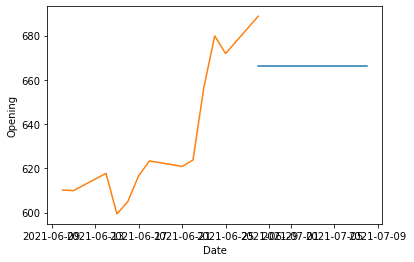

In [94]:
 
_=plt.plot(graph.index,graph['shift_close'])
_=plt.plot(graph.index,graph["Close"])
_=plt.xlabel("Date")
_=plt.ylabel("Opening")
plt.show()

In [67]:
new.index[-14:]

DatetimeIndex(['2021-07-02', '2021-07-05', '2021-07-06', '2021-07-07',
               '2021-07-08', '2021-07-09', '2021-07-12'],
              dtype='datetime64[ns]', name='Date', freq=None)